# Reducing ICESat-2 data files

![Splash](images/splash.png)

* Select files of interest (segment and time)
* Select area of interest (subset lon/lat)
* Reduce selected files with variables of interest
* Filter data and separate tracks into asc/des
* Process/Read each file in parallel
* Plot some data to check everything went well

In [1]:
%matplotlib widget
#%matplotlib inline

## How ICESat-2 files are organized spatially 

ICESat-2 ground tracks are subsetted into granules (individual files)

Granules are then grouped into latitudinal bands (segments)

![Segments](images/segments.png "Latitudinal bands (Segments)")

## File naming convention

`ATL06_20181120202321_08130101_001_01.h5`

`[ATL06]_[yyyy][mmdd][hhmmss]_[RGT][cc][ss]_[rrr]_[vv].h5`

![Naming](images/name-convention.png)  
Source: Figure from Ben Smith

## Download data files

First let's define the product, area and time interval

In [2]:
from pathlib import Path
from icepyx import icesat2data as ipd

# Our data folder 
# data_home = Path('/home/jovyan/tutorial-data/land_ice_applications/PIG_ATL06')
data_home = Path('data')
data_home.mkdir(exist_ok=True)

In [3]:
short_name = 'ATL06'
spatial_extent = [-102, -76, -98, -74.5]  # PIG
date_range = ['2018-10-14','2020-04-01']

# spatial_extent = [148, -81, 162, -80]  # Byrd
# date_range = ['2018-10-14','2018-12-22']

region = ipd.Icesat2Data(short_name, spatial_extent, date_range)

Query available data files without downloading

In [4]:
print('product:    ', region.dataset)
print('dates:      ', region.dates)
print('start time: ', region.start_time)
print('end time:   ', region.end_time)
print('version:    ', region.dataset_version)
print('extent:     ', region.spatial_extent)

print('\nDATA:')
print('\n'.join([str(item) for item in region.avail_granules().items()]))

region.visualize_spatial_extent()

product:     ATL06
dates:       ['2018-10-14', '2020-04-01']
start time:  00:00:00
end time:    23:59:59
version:     003
extent:      ['bounding box', [-102, -76, -98, -74.5]]

DATA:
('Number of available granules', 258)
('Average size of granules (MB)', 22.0827139329562)
('Total size of all granules (MB)', 5697.3401947027)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Login to Earthdata and download the data files

In [5]:
name = 'fspaolo'
email = 'fspaolo@gmail.com'

# Only download if data folder is empty
if not list(data_home.glob('*.h5')):
    region.earthdata_login(name, email)
    region.download_granules(data_home)

Let's check we got the files we wanted 

In [6]:
files = list(data_home.glob('*.h5'))

for f in files[:10]: print(f)
print('Total number of files:', len(files))

data/ATL06_20190101003047_00540212_209_01.h5
data/ATL06_20190101002504_00540211_209_01.h5
data/ATL06_20190101001723_00540210_209_01.h5
Total number of files: 3


## Reducing ICESat-2 files

> **NOTE:** 
> - This is neither the only nor the best way to handled ICESat-2 data files.
> - This is *one* way that works well for large-scale processing (e.g. full continent) on parallel machines (e.g. HPC clusters).
> - The idea is to (a) simplify the I/O of a complex workflow and (b) take advantage of embarrasingly parallelization.

Let's check the ICESat-2 file structure (!)

In [7]:
!h5ls -r {files[0]} 

/                        Group
/METADATA                Group
/METADATA/AcquisitionInformation Group
/METADATA/AcquisitionInformation/lidar Group
/METADATA/AcquisitionInformation/lidarDocument Group
/METADATA/AcquisitionInformation/platform Group
/METADATA/AcquisitionInformation/platformDocument Group
/METADATA/DataQuality    Group
/METADATA/DataQuality/CompletenessOmission Group
/METADATA/DataQuality/DomainConsistency Group
/METADATA/DatasetIdentification Group
/METADATA/Extent         Group
/METADATA/Lineage        Group
/METADATA/Lineage/ANC06-01 Group
/METADATA/Lineage/ANC06-02 Group
/METADATA/Lineage/ANC06-03 Group
/METADATA/Lineage/ANC17  Group
/METADATA/Lineage/ANC19  Group
/METADATA/Lineage/ANC25-06 Group
/METADATA/Lineage/ANC26-06 Group
/METADATA/Lineage/ANC28  Group
/METADATA/Lineage/ANC36-06 Group
/METADATA/Lineage/ANC38-06 Group
/METADATA/Lineage/ATL03  Group
/METADATA/Lineage/ATL09  Group
/METADATA/Lineage/Control Group
/METADATA/ProcessStep    Group
/METADATA/ProcessStep/

Let's code a simple reader that:

- Select variables of interest `(x, y, t, h, ...)`  
- Filter data points based on quality flag and bbox   
- Separate into beams and ascending/descending tracks  
- Save data to a simpler HDF5 structure (NOTE: redundancy vs. efficiency)

Some utility functions

In [8]:
import pyproj
from astropy.time import Time

def gps2dyr(time):
    """Converte GPS time to decimal years."""
    return Time(time, format='gps').decimalyear


def orbit_type(time, lat, tmax=1):
    """Separate tracks into ascending and descending.
    
    Defines tracks as segments with time breaks > tmax,
    and tests whether lat increases or decreases w/time.
    """
    tracks = np.zeros(lat.shape)  # generate track segment
    tracks[0:np.argmax(np.abs(lat))] = 1  # set values for segment
    is_asc = np.zeros(tracks.shape, dtype=bool)  # output index array

    # Loop trough individual secments
    for track in np.unique(tracks):
    
        i_track, = np.where(track == tracks)  # get all pts from seg
    
        if len(i_track) < 2: continue
    
        # Test if lat increases (asc) or decreases (des) w/time
        i_min = time[i_track].argmin()
        i_max = time[i_track].argmax()
        lat_diff = lat[i_track][i_max] - lat[i_track][i_min]
    
        # Determine track type
        if lat_diff > 0:  is_asc[i_track] = True
    
    return is_asc


def transform_coord(proj1, proj2, x, y):
    """Transform coordinates from proj1 to proj2 (EPSG num).

    Example EPSG projections:
        Geodetic (lon/lat): 4326
        Polar Stereo AnIS (x/y): 3031
        Polar Stereo GrIS (x/y): 3413
    """
    # Set full EPSG projection strings
    proj1 = pyproj.Proj("+init=EPSG:"+str(proj1))
    proj2 = pyproj.Proj("+init=EPSG:"+str(proj2))
    return pyproj.transform(proj1, proj2, x, y)  # convert


The simple reader

In [9]:
import h5py
import numpy as np

def read_atl06(fname, outdir='data', bbox=None):
    """Read one ATL06 file and output 6 reduced files. 
    
    Extract variables of interest and separate the ATL06 file 
    into each beam (ground track) and ascending/descending orbits.
    """

    # Each beam is a group
    group = ['/gt1l', '/gt1r', '/gt2l', '/gt2r', '/gt3l', '/gt3r']

    # Loop trough beams
    for k, g in enumerate(group):
    
        #-----------------------------------#
        # 1) Read in data for a single beam #
        #-----------------------------------#
        
        data = {}
    
        try:
            # Load vars into memory (include as many as you want)
            with h5py.File(fname, 'r') as fi:
                
                data['lat'] = fi[g+'/land_ice_segments/latitude'][:]
                data['lon'] = fi[g+'/land_ice_segments/longitude'][:]
                data['h_li'] = fi[g+'/land_ice_segments/h_li'][:]
                data['s_li'] = fi[g+'/land_ice_segments/h_li_sigma'][:]
                data['t_dt'] = fi[g+'/land_ice_segments/delta_time'][:]
                data['q_flag'] = fi[g+'/land_ice_segments/atl06_quality_summary'][:]
                data['s_fg'] = fi[g+'/land_ice_segments/fit_statistics/signal_selection_source'][:]
                data['snr'] = fi[g+'/land_ice_segments/fit_statistics/snr_significance'][:]
                data['h_rb'] = fi[g+'/land_ice_segments/fit_statistics/h_robust_sprd'][:]
                data['dac'] = fi[g+'/land_ice_segments/geophysical/dac'][:]
                data['f_sn'] = fi[g+'/land_ice_segments/geophysical/bsnow_conf'][:]
                data['dh_fit_dx'] = fi[g+'/land_ice_segments/fit_statistics/dh_fit_dx'][:]
                data['tide_earth'] = fi[g+'/land_ice_segments/geophysical/tide_earth'][:]
                data['tide_load'] = fi[g+'/land_ice_segments/geophysical/tide_load'][:]
                data['tide_ocean'] = fi[g+'/land_ice_segments/geophysical/tide_ocean'][:]
                data['tide_pole'] = fi[g+'/land_ice_segments/geophysical/tide_pole'][:]
                
                rgt = fi['/orbit_info/rgt'][:]                           # single value
                t_ref = fi['/ancillary_data/atlas_sdp_gps_epoch'][:]     # single value
                beam_type = fi[g].attrs["atlas_beam_type"].decode()      # str: strong/weak
                spot_number = fi[g].attrs["atlas_spot_number"].decode()  # str: number
                
        except:
            print('skeeping group:', g)
            print('in file:', fname)
            continue
            
        #---------------------------------------------#
        # 2) Filter data according region and quality #
        #---------------------------------------------#
        
        # Select a region of interest
        if bbox:
            lonmin, lonmax, latmin, latmax = bbox
            bbox_mask = (data['lon'] >= lonmin) & (data['lon'] <= lonmax) & \
                        (data['lat'] >= latmin) & (data['lat'] <= latmax)
        else:
            bbox_mask = np.ones_like(data['lat'], dtype=bool)  # get all
            
        # Only keep good data (quality flag + threshold + bbox)
        mask = (data['q_flag'] == 0) & (np.abs(data['h_li']) < 10e3) & (bbox_mask == 1)
        
        # If no data left, skeep
        if not any(mask): continue
        
        # Update data variables
        for k, v in data.items(): data[k] = v[mask]
            
        #-------------------------------------#
        # 3) Convert time and separate tracks #
        #-------------------------------------#
        
        # Time in GPS seconds (secs sinde Jan 5, 1980)
        t_gps = t_ref + data['t_dt']

        # Time in decimal years
        t_year = gps2dyr(t_gps)

        # Determine orbit type
        is_asc = orbit_type(t_year, data['lat'])
        
        data['t_gps'] = t_gps
        data['t_year'] = t_year
        data['is_asc'] = is_asc
        
        #-----------------------#
        # 4) Save selected data #
        #-----------------------#
        
        # Define output dir and file
        outdir = Path(outdir)    
        fname = Path(fname)
        outdir.mkdir(exist_ok=True)
        outfile = outdir / fname.name.replace('.h5', '_' + g[1:] + '.h5')
        
        # Save variables
        with h5py.File(outfile, 'w') as fo:
            for k, v in data.items(): fo[k] = v
            print('out ->', outfile)
                

## Simple parallelization

* If your problem is embarrasingly parallel, it's easy to parallelize
* We can use the very simple and lightweight `joblib` library
* There is no need to modify your code!

Read more: [https://joblib.readthedocs.io](https://joblib.readthedocs.io)

Let's check the available resources first

In [10]:
!python system-status.py

I am currently running on Darwin version 18.7.0.  
This system is named LMC-061769 
It has 8 CPU cores.  
It has 16 Gigabytes of RAM.  
Current disk_percent is 95.3 percent.  
Current CPU utilization is 28.6 percent.  
Current memory utilization is 66.2 percent. 
it's running since Sunday 07. June 2020. 



Let's run our reader

In [11]:
outdir = 'data-out'
njobs = 3

bbox = None #[-1124782, 81623, -919821, -96334]  # Kamb bounding box

if njobs == 1:
    print('running in serial ...')
    [read_atl06(f, outdir, bbox) for f in files]

else:
    print('running in parallel (%d jobs) ...' % njobs)
    from joblib import Parallel, delayed
    Parallel(n_jobs=njobs, verbose=5)(delayed(read_atl06)(f, outdir, bbox) for f in files)


running in parallel (3 jobs) ...


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.7s finished


Let's check our created files

In [12]:
outfiles = !ls {outdir}/*.h5

for f in outfiles[:10]: print(f)
print('total number of files:', len(outfiles))

data-out/ATL06_20190101001723_00540210_209_01_gt1l.h5
data-out/ATL06_20190101001723_00540210_209_01_gt1r.h5
data-out/ATL06_20190101001723_00540210_209_01_gt2l.h5
data-out/ATL06_20190101001723_00540210_209_01_gt2r.h5
data-out/ATL06_20190101001723_00540210_209_01_gt3l.h5
data-out/ATL06_20190101001723_00540210_209_01_gt3r.h5
data-out/ATL06_20190101002504_00540211_209_01_gt1l.h5
data-out/ATL06_20190101002504_00540211_209_01_gt1r.h5
data-out/ATL06_20190101002504_00540211_209_01_gt2l.h5
data-out/ATL06_20190101002504_00540211_209_01_gt2r.h5
total number of files: 18


In [13]:
!h5ls -r {outfiles[0]}

/                        Group
/dac                     Dataset {33573}
/dh_fit_dx               Dataset {33573}
/f_sn                    Dataset {33573}
/h_li                    Dataset {33573}
/h_rb                    Dataset {33573}
/is_asc                  Dataset {33573}
/lat                     Dataset {33573}
/lon                     Dataset {33573}
/q_flag                  Dataset {33573}
/s_fg                    Dataset {33573}
/s_li                    Dataset {33573}
/snr                     Dataset {33573}
/t_dt                    Dataset {33573}
/t_gps                   Dataset {33573}
/t_year                  Dataset {33573}
/tide_earth              Dataset {33573}
/tide_load               Dataset {33573}
/tide_ocean              Dataset {33573}
/tide_pole               Dataset {33573}


## How to handle and visualize millions of points? 

* dask.dataframe - xxx 
* datashader - yyy

Reading data now becomes trivial!!!

In [38]:
import h5py
import numpy as np

import dask.dataframe as dd

import warnings
warnings.filterwarnings("ignore")


def read_h5(fname, vnames=[]):
    """Extremely simple HDF5 reader: [v1, v2, ..] -> 2D."""
    with h5py.File(fname, 'r') as f:
        return np.column_stack([f[v][()] for v in vnames])

    
# Get list of files to plot
files = list(Path(outdir).glob('*.h5'))

# Variables we want to plot
vnames = ['lon', 'lat', 'h_li']

# List with one dataframe per file
dfs = [dd.from_array(read_h5(f, vnames), columns=vnames) for f in files]

# Single parallel dataframe (larger than memory)
df = dd.concat(dfs)

print('Number of files:', len(files))
print('Number of points:', len(df))
print(df.head())

Number of files: 18
Number of points: 762960
         lon        lat         h_li
0 -12.350823 -65.087842  1768.038940
1 -12.365644 -65.143231     6.546876
2 -12.366486 -65.146427     6.474681
3 -12.421831 -65.353073     6.605453
4 -12.625161 -66.091438     6.345798


Plotting data now be

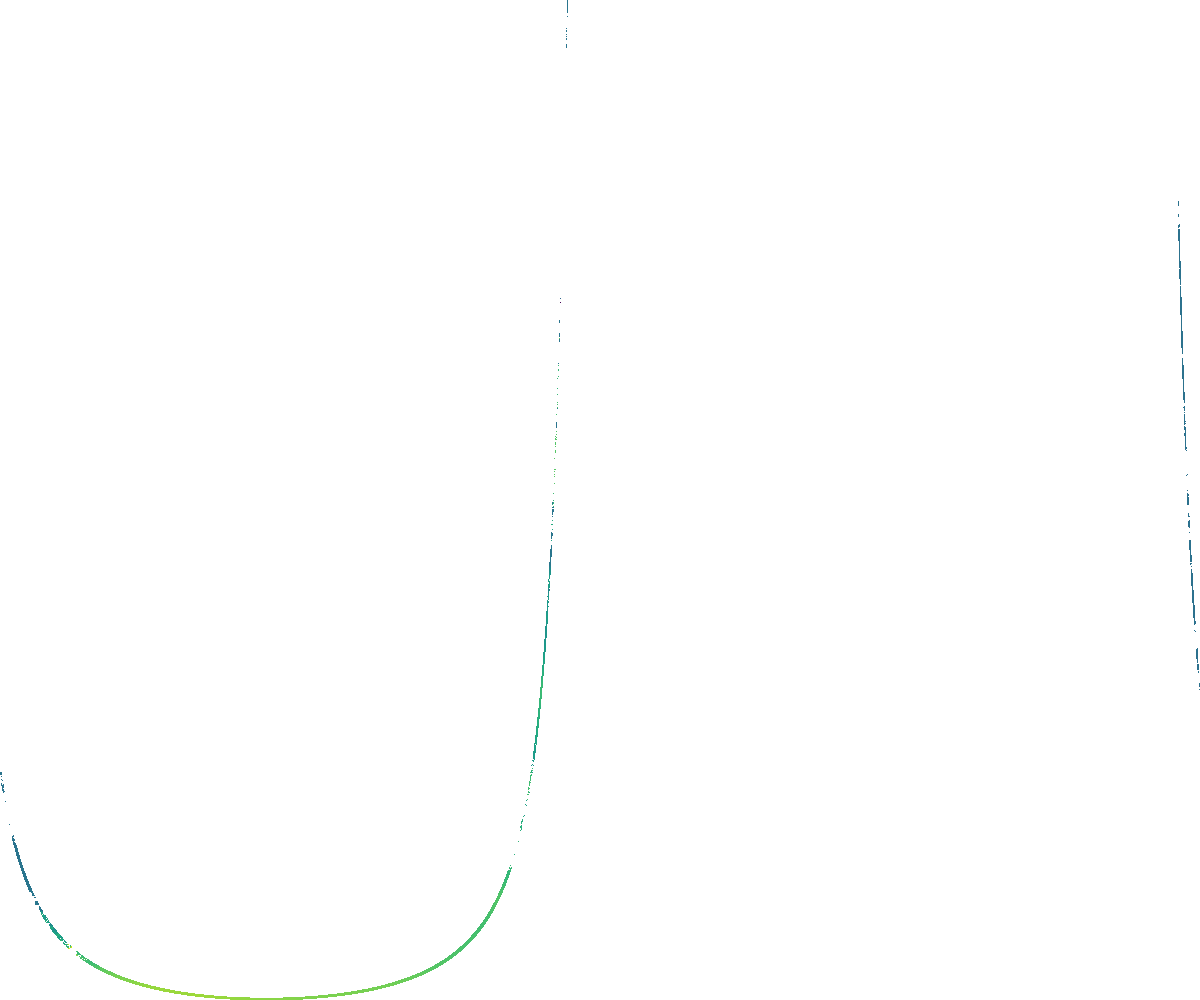

In [41]:
import datashader as ds
import datashader.transfer_functions as tf
from matplotlib.cm import viridis

pts = ds.Canvas(plot_width=1200, plot_height=1000)
agg = pts.points(df, 'lon', 'lat', ds.mean('h_li'))
img = tf.shade(agg, cmap=viridis, how='linear')
img

## Single program from the command line

You can put all of the above (and more) into a single script and run it on the command line:

In [79]:
!python readatl06.py -h

usage: readatl06.py [-h] [-o outdir] [-f fmask] [-l efile] [-b w e s n] [-n njobs] [-p epsg]
                    [-i index] [-g granule [granule ...]]
                    ifile [ifile ...]

Read ICESat-2 ATL06 data files.

positional arguments:
  ifile                 input files to read (.h5).

optional arguments:
  -h, --help            show this help message and exit
  -o outdir             path to output folder
  -f fmask              raster mask with 0s and 1s ('.tif' or '.h5')
  -l efile              blacklist file if available ('.txt')
  -b w e s n            bounding box for geographical region (deg)
  -n njobs              number of cores to use for parallel processing
  -p epsg               projection for mask (EPSG number)
  -i index              unique mission id (appended to original)
  -g granule [granule ...]
                        select specific granules


Try reading the ICESat-2 files in parallel from the command line:

In [82]:
!python readatl06.py {data_home}/*.h5 -o {outdir} -n 3

running in parallel (3 jobs) ...
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
data-out/ATL06_20190101001723_00540210_209_01_gt1l_spot1_D.h5
data-out/ATL06_20190101003047_00540212_209_01_gt1l_spot1_A.h5
data-out/ATL06_20190101001723_00540210_209_01_gt1r_spot2_D.h5
data-out/ATL06_20190101002504_00540211_209_01_gt1l_spot1_D.h5
data-out/ATL06_20190101003047_00540212_209_01_gt1r_spot2_A.h5
data-out/ATL06_20190101001723_00540210_209_01_gt2l_spot3_D.h5
data-out/ATL06_20190101003047_00540212_209_01_gt2l_spot3_A.h5
data-out/ATL06_20190101002504_00540211_209_01_gt1r_spot2_D.h5
data-out/ATL06_20190101001723_00540210_209_01_gt2r_spot4_D.h5
data-out/ATL06_20190101003047_00540212_209_01_gt2r_spot4_A.h5
data-out/ATL06_20190101001723_00540210_209_01_gt3l_spot5_D.h5
data-out/ATL06_20190101003047_00540212_209_01_gt3l_spot5_A.h5
data-out/ATL06_20190101002504_00540211_209_01_gt2l_spot3_D.h5
data-out/ATL06_20190101001723_00540210_209_01_gt3r_spot6_D.h5
data-out/ATL06_201901010

In [80]:
#!cat readatl06.py

#!/usr/bin/env python
"""
Read ICESat-2 ATL06 data into single track format.

Reads the ATL06 file format and outputs separate files for each beam pair
and provides information in the file name if the orbit is ascending or
descending.

The observations output if they flagged valid by the "atl06_quality_summary"
flag, pass the segmentation filter (2 m tolerance) and are located inside the
ROI, defined by either a mask or a bounding box.

Mask can be passed as either a ".tif" file or ".h5" file containing 0 (off)
or 1 (on) masking values. If hdf5 used please use (X Y Z) as variable names,
as they are
hardcoded.

User can provide a blacklist (".txt" file) of ATL06 file names that should
not be processed.

Notes:
    The unique mission index ('-i') is used to separate different mission to
    avoid tracks having the same orbit number. The number provided is
    appended to the front of the current orbit number:
    orbit_new = str(unique) + str(orbit_i) = int('100') + int('1100')
    = int

> **NOTE:** Please remove your created files at the end:

    cd ~/shared/data-lastname
    rm *.h5